## 13<sup>th</sup> of April, 2020
## Benjamin Adam Catching
## Coronavirus Simulation
## Andino Lab

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
sns.set(style="ticks")

0


KeyboardInterrupt: 

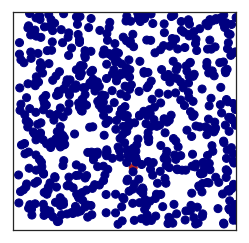

In [3]:
# Fixing random state for reproducibility
np.random.seed(100)

# Figure ratio
fig_rat = .4
# Number of steps
N_steps = 120
# Number of agents
n_agents = int(4000 * round(fig_rat ** 2, 2))
# Set delta t
dt = .1
# Set velocity
velo = 4
# Set percent of sheltering in place
per_shelt = 0
# Set boundaries
xboundaries = [0, 50 * fig_rat]
yboundaries = [0, 50 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

# Define the figure
fig = plt.figure(figsize=(10 * fig_rat, 10 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
plt.xticks([])
plt.yticks([])


# lists to store x and y axis points 
agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                  ('velocity', float, 2),
                                  ('color', str, 20),
                                  ('state', str, 20),
                                  ('time', int, 1),
                                  ('touch', int, 1),
                                  ('symptomatic', int, 1),
                                  ('num infected', int, 1)])

# Define the initial positions
agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))

# Define the initial velocity angles
init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
# Get initial x and y velocities from angles
velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) * velo
# Get percentage of agents 'sheltering'
num_shelt = int(per_shelt * n_agents)
# Make sheltering agents static
velocities[:num_shelt] = np.zeros((num_shelt, 2))
# Number of cycles for asymptomatic infection (hours)
asympt_infectious = 24 * 5.1
# Number of cycles for symptomatic infection (hours)
sympt_infectious = 12
# Define values for infection gamma pdf
g_shape, g_scale = 0.25, 4
# Probability reduction for asymptomatic carrier
asym_prob = .66

# Assign values to agents
agents['velocity'] = velocities
agents['color'] = np.array(['Navy'] * n_agents)
agents['state'] = np.array(['Susceptible'] * n_agents)
agents['time'] = np.array([0] * n_agents)
agents['num infected'] = np.zeros(n_agents)
agents['symptomatic'] = np.zeros(n_agents)

# Make the one agent infected
agents['color'][0] = 'Firebrick'
agents['state'][0] = 'Infected'
agents['time'][0] = 1
agents['symptomatic'][0] = 1
agents['velocity'][0] = velocities[0]

# Initialize the plot
scatter = ax.scatter(agents['position'][:, 0], agents['position'][:, 1], 
                     color=agents['color'], s=64)
# Initialize lists storing number of infected and recovered
num_infected_sym = [sum(agents['state']=='Infected')]
num_recovered = [0]

def update(i):
    if i % 10 == 0:
        print(i)
    # Define the new time
    t = i * dt + dt
    # Store all interactions
    interactions = np.zeros(n_agents)
    
    # Iterate over all agents 
    for j in range(n_agents):
        if agents['time'][j] != 0:
            if agents['state'][j] == 'Infected' and agents['symptomatic'][j] == 0:
                if agents['time'][j] >= asympt_infectious:
                    
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 0
                elif agents['state'][j] == 'Infected' :
                    agents['time'][j] += 1
            elif agents['state'][j] == 'Infected' and agents['symptomatic'][j] == 1:
                if agents['time'][j] >= sympt_infectious:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 0
                elif agents['state'][j] == 'Infected' :
                    agents['time'][j] += 1
        # New displacements (prior velocity times change in time)
        deltax_temp = dt * agents['velocity'][j, 0]
        deltay_temp = dt * agents['velocity'][j, 1]
        # New positions
        x = agents['position'][j, 0] + deltax_temp
        y = agents['position'][j, 1] + deltay_temp
        # Compute new velocity
        vx_temp = deltax_temp / dt
        vy_temp = deltay_temp / dt
        
        # Add interaction
        for k in range(n_agents):
            # Go through all other agents that could be interacted with
            if interactions[k] == 0:
                if k != j:
                    # Compute components of distance
                    dx = agents['position'][j, 0] - agents['position'][k, 0]
                    dy = agents['position'][j, 1] - agents['position'][k, 1]
                    # Compute distance between agents
                    dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                    # If distance of interaction is closer than both radii, collide
                    if dist_temp <= .5:
                        agents['touch'][j] += 1
                        if agents['state'][j] == 'Infected' and agents['state'][k] == 'Susceptible':
                            if agents['symptomatic'][j] == 1:
                                if np.random.gamma(shape=g_shape, scale=g_scale) >= 1:
                                    agents['state'][k] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Goldenrod'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                            else:
                                if np.random.gamma(shape=g_shape, scale=g_scale) * asym_prob >=1:
                                    agents['state'][k] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Goldenrod'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                        elif agents['state'][k] == 'Infected' and agents['state'][j] == 'Susceptible':
                            if agents['symptomatic'][k] == 1:
                                if np.random.gamma(shape=g_shape, scale=g_scale) >= 1:
                                    agents['state'][j] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][j] = 1
                                        agents['color'][j] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][j] = 0
                                        agents['color'][j] = 'Goldenrod'
                                    agents['time'][j] = 1
                                    agents['num infected'][k] += 1
                            else:
                                if np.random.gamma(shape=g_shape, scale=g_scale) * asym_prob >=1:
                                    agents['state'][j] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][j] = 1
                                        agents['color'][j] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][j] = 0
                                        agents['color'][j] = 'Goldenrod'
                                    agents['time'][j] = 1
                                    agents['num infected'][k] += 1
        if x >= xmax:
            x = 2 * xmax - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif x <= 0:
            x = - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif y >= ymax:
            y = 2 * ymax - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        elif y <= 0:
            y = - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        # Pick a new position for oldest rain drop, resetting its size,
        # color and growth factor.
        
        agents['position'][j] = np.array([x, y])
        agents['velocity'][j, 0] = vx_temp
        agents['velocity'][j, 1] = vy_temp
        interactions[j] = 1
        # Update the scatter collection, with the new colors, sizes and positions.
        scatter.set_color(agents['color'])
        scatter.set_offsets(agents['position'])
    temp = sum(agents[agents['state']=='Infected']['symptomatic'] == 1)
    num_infected_sym.append(temp)
    temp = sum(agents[agents['state']=='Recovered']['symptomatic'] == 1)
    num_recovered.append(temp)
animation = FuncAnimation(fig, update, frames=N_steps, interval=24)

animation.save('interaction_test_3.gif', writer='imagemagick', dpi=100)
plt.show()

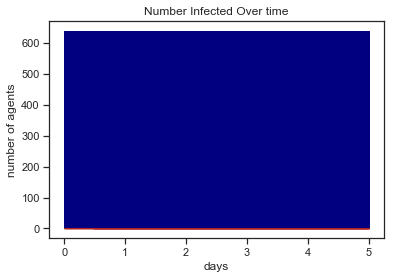

In [106]:
_ = plt.fill_between(np.linspace(0, 5, N_steps + 3), np.ones(N_steps + 3) * n_agents, color='navy', label='susceptible')
_ = plt.fill_between(np.linspace(0, 5, N_steps + 3), np.array(num_infected) + np.array(num_recovered), color='darkgreen', label='recovered')
_ = plt.fill_between(np.linspace(0, 5, N_steps + 3), num_infected, color='firebrick', label='infected')
_ = plt.xlabel('days')
_ = plt.ylabel('number of agents')
_ = plt.title('Number Infected Over time')

In [100]:
sum(agents[agents['symptomatic'] == 1]['num infected'] != 0) / len(agents['symptomatic'] == 1)

0.2921875

In [101]:
sum(agents[agents['symptomatic'] == 0]['num infected'] != 0) / len(agents['symptomatic'] == 0)

0.246875

In [104]:
len(agents[agents['symptomatic'] == 1]['num infected'] != 0) 

640

0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
0


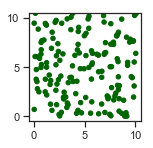

In [171]:
# Fixing random state for reproducibility
np.random.seed(100)

# Figure ratio
fig_rat = .2
# Number of steps
N_steps = 240
# Number of agents
n_agents = int(4000 * round(fig_rat ** 2, 2))
# Set delta t
dt = .1
# Set velocity
velo = 2
# Set percent of sheltering in place
per_shelt = 0
# Set boundaries
xboundaries = [0, 50 * fig_rat]
yboundaries = [0, 50 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

# Define the figure
fig = plt.figure(figsize=(10 * fig_rat, 10 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
#plt.xticks([])
#plt.yticks([])


# lists to store x and y axis points 
agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                  ('velocity', float, 2),
                                  ('color', str, 20),
                                  ('state', str, 20),
                                  ('time', int, 1),
                                  ('touch', int, 1),
                                  ('symptomatic', int, 1),
                                  ('num infected', int, 1)])

# Define the initial positions
agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))

# Define the initial velocity angles
init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
# Get initial x and y velocities from angles
velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) * velo
# Get percentage of agents 'sheltering'
num_shelt = int(per_shelt * n_agents)
# Make sheltering agents static
velocities[:num_shelt] = np.zeros((num_shelt, 2))
# Number of cycles for asymptomatic infection (hours)
asympt_infectious = 24 * 5.1
# Number of cycles for symptomatic infection (hours)
sympt_infectious = 12
# Define values for infection gamma pdf
g_shape, g_scale = 0.25, 4
# Probability reduction for asymptomatic carrier
asym_prob = .66

# Assign values to agents
agents['velocity'] = velocities
agents['color'] = np.array(['Navy'] * n_agents)
agents['state'] = np.array(['Susceptible'] * n_agents)
agents['time'] = np.array([0] * n_agents)
agents['num infected'] = np.zeros(n_agents)
agents['symptomatic'] = np.zeros(n_agents)

# Make the one agent infected
agents['color'][0] = 'Firebrick'
agents['state'][0] = 'Infected'
agents['time'][0] = 1
agents['symptomatic'] = 1
agents['velocity'][0] = velocities[0]

# Initialize the plot
scatter = ax.scatter(agents['position'][:, 0], agents['position'][:, 1], 
                     color=agents['color'], s=100*fig_rat)
# Initialize lists storing number of infected and recovered
num_infected_sym = [sum(agents['state']=='Infected')]
num_recovered = [0]

def update(i):
    if i % 10 == 0:
        print(i)
    # Define the new time
    t = i * dt + dt
    # Store all interactions
    interactions = np.zeros(n_agents)
    
    # Iterate over all agents 
    for j in range(n_agents):
        if agents['time'][j] != 0:
            if agents['state'][j] == 'Infected' and agents['symptomatic'][j] == 0:
                if agents['time'][j] >= asympt_infectious:
                    
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 0
                elif agents['state'][j] == 'Infected' :
                    agents['time'][j] += 1
            elif agents['state'][j] == 'Infected' and agents['symptomatic'][j] == 1:
                if agents['time'][j] >= sympt_infectious:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 0
                elif agents['state'][j] == 'Infected' :
                    agents['time'][j] += 1
        # New displacements (prior velocity times change in time)
        deltax_temp = dt * agents['velocity'][j, 0]
        deltay_temp = dt * agents['velocity'][j, 1]
        # New positions
        x = agents['position'][j, 0] + deltax_temp
        y = agents['position'][j, 1] + deltay_temp
        # Compute new velocity
        vx_temp = deltax_temp / dt
        vy_temp = deltay_temp / dt
        
        # Add interaction
        for k in range(n_agents):
            # Go through all other agents that could be interacted with
            if interactions[k] == 0:
                if k != j:
                    # Compute components of distance
                    dx = agents['position'][j, 0] - agents['position'][k, 0]
                    dy = agents['position'][j, 1] - agents['position'][k, 1]
                    # Compute distance between agents
                    dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                    # If distance of interaction is closer than both radii, collide
                    if dist_temp <= .5:
                        agents['touch'][j] += 1
                        if agents['state'][j] == 'Infected' and agents['state'][k] == 'Susceptible':
                            if agents['symptomatic'][j] == 1:
                                agents['state'][k] = 'Infected'
                                if np.random.random() >= .5:
                                    agents['symptomatic'][k] = 1
                                    agents['color'][k] = 'Firebrick'
                                else:
                                    agents['symptomatic'][k] = 0
                                    agents['color'][k] = 'Goldenrod'
                                agents['time'][k] = 1
                                agents['num infected'][j] += 1
                            else:
                                if np.random.random() <= asym_prob:
                                    agents['state'][k] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Goldenrod'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                        elif agents['state'][k] == 'Infected' and agents['state'][j] == 'Susceptible':
                            if agents['symptomatic'][k] == 1:
                                agents['state'][j] = 'Infected'
                                if np.random.random() >= .5:
                                    agents['symptomatic'][j] = 1
                                    agents['color'][j] = 'Firebrick'
                                else:
                                    agents['symptomatic'][j] = 0
                                    agents['color'][j] = 'Goldenrod'
                                agents['time'][j] = 1
                                agents['num infected'][k] += 1
                            else:
                                if np.random.random() <= asym_prob:
                                    agents['state'][j] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][j] = 1
                                        agents['color'][j] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][j] = 0
                                        agents['color'][j] = 'Goldenrod'
                                    agents['time'][j] = 1
                                    agents['num infected'][k] += 1
        if x >= xmax:
            x = 2 * xmax - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif x <= 0:
            x = - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif y >= ymax:
            y = 2 * ymax - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        elif y <= 0:
            y = - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        # Pick a new position for oldest rain drop, resetting its size,
        # color and growth factor.
        
        agents['position'][j] = np.array([x, y])
        agents['velocity'][j, 0] = vx_temp
        agents['velocity'][j, 1] = vy_temp
        interactions[j] = 1
        # Update the scatter collection, with the new colors, sizes and positions.
        scatter.set_color(agents['color'])
        scatter.set_offsets(agents['position'])
    temp = sum(agents[agents['state']=='Infected']['symptomatic'])
    num_infected_sym.append(temp)
    temp = sum(agents[agents['state']=='Recovered']['symptomatic'])
    num_recovered.append(temp)
animation = FuncAnimation(fig, update, frames=N_steps, interval=24)

animation.save('interaction_test_5.gif', writer='imagemagick', dpi=100)
plt.show()

243
243


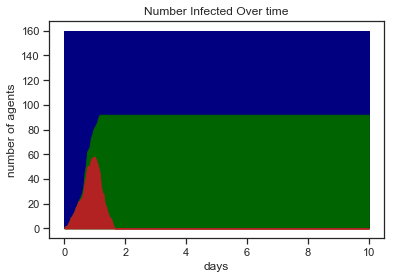

In [170]:
print(len(num_infected_sym))
_ = plt.fill_between(np.linspace(0, 10, N_steps + 3), np.ones(N_steps + 3) * n_agents, color='navy', label='susceptible')
_ = plt.fill_between(np.linspace(0, 10, N_steps + 3), np.array(num_infected_sym) + np.array(num_recovered), color='darkgreen', label='recovered')
_ = plt.fill_between(np.linspace(0, 10, N_steps + 3), num_infected_sym, color='firebrick', label='infected')
_ = plt.xlabel('days')
_ = plt.ylabel('number of agents')
_ = plt.title('Number Infected Over time')
print(len(num_recovered))

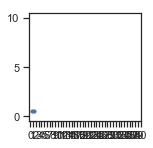

In [163]:
# Define the figure
fig_rat =.1
xboundaries = [0, 100 * fig_rat]
yboundaries = [0, 100 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5
fig = plt.figure(figsize=(20 * fig_rat, 20 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
plt.xticks(np.linspace(0,40,41))
scatter = ax.scatter([0.5, 1.5], [0.5, 0.5], color='b', s=100*fig_rat)

Calculation of number mean free path:  
$$l = \frac{A}{d N}$$  
Where $A$ is the area, $d$ is the diameter of the agent, and $N$ is the number of particles. For $A=100$, $d=1$, and $N = 160$, $l = 10$. As the velocity is set to 4 right now, a single infected agent with symptoms interacts with about 4.8 other individuals before being isolated. If that value is modified to 2 then the agent interacts with 2.4 other agents before it is isolated. 

In [180]:
g_test = np.random.gamma(shape=g_shape, scale=g_scale, size=2000)
g_used = np.zeros(2000)
for i, x in enumerate(g_test):
    if x <= 1:
        g_used[i] = x
    else:
        g_used[i] = 1
print(g_test.mean(), g_used.mean())

1.0041927676071816 0.40059137044893656


0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
0


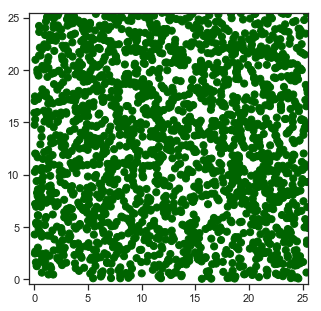

In [190]:
# Fixing random state for reproducibility
np.random.seed(100)

# Figure ratio
fig_rat = .5
# Number of steps
N_steps = 240
# Number of agents
n_agents = int(8000 * round(fig_rat ** 2, 2))
# Set delta t
dt = .1
# Set velocity
velo = 4.8
# Set percent of sheltering in place
per_shelt = 0
# Set boundaries
xboundaries = [0, 50 * fig_rat]
yboundaries = [0, 50 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

# Define the figure
fig = plt.figure(figsize=(10 * fig_rat, 10 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
#plt.xticks([])
#plt.yticks([])


# lists to store x and y axis points 
agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                  ('velocity', float, 2),
                                  ('color', str, 20),
                                  ('state', str, 20),
                                  ('time', int, 1),
                                  ('touch', int, 1),
                                  ('symptomatic', int, 1),
                                  ('num infected', int, 1)])

# Define the initial positions
agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))

# Define the initial velocity angles
init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
# Get initial x and y velocities from angles
velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) * velo
# Get percentage of agents 'sheltering'
num_shelt = int(per_shelt * n_agents)
# Make sheltering agents static
velocities[:num_shelt] = np.zeros((num_shelt, 2))
# Number of cycles for asymptomatic infection (hours)
asympt_infectious = 24 * 5.1
# Number of cycles for symptomatic infection (hours)
sympt_infectious = 12
# Define values for infection gamma pdf
g_shape, g_scale = 0.25, 4
# Probability reduction for asymptomatic carrier
asym_prob = .66

# Assign values to agents
agents['velocity'] = velocities
agents['color'] = np.array(['Navy'] * n_agents)
agents['state'] = np.array(['Susceptible'] * n_agents)
agents['time'] = np.array([0] * n_agents)
agents['num infected'] = np.zeros(n_agents)
agents['symptomatic'] = np.zeros(n_agents)

# Make the one agent infected
agents['color'][0] = 'Firebrick'
agents['state'][0] = 'Infected'
agents['time'][0] = 1
agents['symptomatic'] = 1
agents['velocity'][0] = velocities[0]

# Initialize the plot
scatter = ax.scatter(agents['position'][:, 0], agents['position'][:, 1], 
                     color=agents['color'], s=100*fig_rat)
# Initialize lists storing number of infected and recovered
num_infected_sym = [sum(agents['state']=='Infected')]
num_recovered = [0]

def update(i):
    if i % 10 == 0:
        print(i)
    # Define the new time
    t = i * dt + dt
    # Store all interactions
    interactions = np.zeros(n_agents)
    
    # Iterate over all agents 
    for j in range(n_agents):
        if agents['time'][j] != 0:
            if agents['state'][j] == 'Infected' and agents['symptomatic'][j] == 0:
                if agents['time'][j] >= asympt_infectious:
                    
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 0
                elif agents['state'][j] == 'Infected' :
                    agents['time'][j] += 1
            elif agents['state'][j] == 'Infected' and agents['symptomatic'][j] == 1:
                if agents['time'][j] >= sympt_infectious:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 0
                elif agents['state'][j] == 'Infected' :
                    agents['time'][j] += 1
        # New displacements (prior velocity times change in time)
        deltax_temp = dt * agents['velocity'][j, 0]
        deltay_temp = dt * agents['velocity'][j, 1]
        # New positions
        x = agents['position'][j, 0] + deltax_temp
        y = agents['position'][j, 1] + deltay_temp
        # Compute new velocity
        vx_temp = deltax_temp / dt
        vy_temp = deltay_temp / dt
        
        # Add interaction
        for k in range(n_agents):
            # Go through all other agents that could be interacted with
            if interactions[k] == 0:
                if k != j:
                    # Compute components of distance
                    dx = agents['position'][j, 0] - agents['position'][k, 0]
                    dy = agents['position'][j, 1] - agents['position'][k, 1]
                    # Compute distance between agents
                    dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                    # If distance of interaction is closer than both radii, collide
                    if dist_temp <= 1:
                        agents['touch'][j] += 1
                        if agents['state'][j] == 'Infected' and agents['state'][k] == 'Susceptible':
                            if agents['symptomatic'][j] == 1:
                                if np.random.gamma(shape=g_shape, scale=g_scale) >= 1:
                                    agents['state'][k] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Goldenrod'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                            else:
                                if np.random.gamma(shape=g_shape, scale=g_scale) * asym_prob >=1:
                                    agents['state'][k] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Goldenrod'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                        elif agents['state'][k] == 'Infected' and agents['state'][j] == 'Susceptible':
                            if agents['symptomatic'][k] == 1:
                                if np.random.gamma(shape=g_shape, scale=g_scale) >= 1:
                                    agents['state'][j] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][j] = 1
                                        agents['color'][j] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][j] = 0
                                        agents['color'][j] = 'Goldenrod'
                                    agents['time'][j] = 1
                                    agents['num infected'][k] += 1
                            else:
                                if np.random.gamma(shape=g_shape, scale=g_scale) * asym_prob >=1:
                                    agents['state'][j] = 'Infected'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][j] = 1
                                        agents['color'][j] = 'Firebrick'
                                    else:
                                        agents['symptomatic'][j] = 0
                                        agents['color'][j] = 'Goldenrod'
                                    agents['time'][j] = 1
                                    agents['num infected'][k] += 1
        if x >= xmax:
            x = 2 * xmax - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif x <= 0:
            x = - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif y >= ymax:
            y = 2 * ymax - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        elif y <= 0:
            y = - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        # Pick a new position for oldest rain drop, resetting its size,
        # color and growth factor.
        
        agents['position'][j] = np.array([x, y])
        agents['velocity'][j, 0] = vx_temp
        agents['velocity'][j, 1] = vy_temp
        interactions[j] = 1
        # Update the scatter collection, with the new colors, sizes and positions.
        scatter.set_color(agents['color'])
        scatter.set_offsets(agents['position'])
    temp = sum(agents[agents['state']=='Infected']['symptomatic'])
    num_infected_sym.append(temp)
    temp = sum(agents[agents['state']=='Recovered']['symptomatic'])
    num_recovered.append(temp)
animation = FuncAnimation(fig, update, frames=N_steps, interval=24)

animation.save('interaction_test_6.gif', writer='imagemagick', dpi=100)
plt.show()

$l = 5$, probability of infecting another agent is .4, and there are 12 cycles between infection and sequestering, the velocity is required to be

243
243


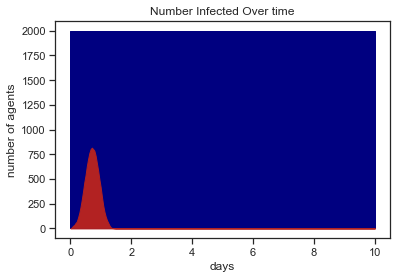

In [192]:
print(len(num_infected_sym))
_ = plt.fill_between(np.linspace(0, 10, N_steps + 3), np.ones(N_steps + 3) * n_agents, color='navy', label='susceptible')
_ = plt.fill_between(np.linspace(0, 10, N_steps + 3), num_infected_sym, color='firebrick', label='infected')
_ = plt.xlabel('days')
_ = plt.ylabel('number of agents')
_ = plt.title('Number Infected Over time')
print(len(num_recovered))